In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

import keras
import keras.backend
from keras import layers
from keras import models
from keras import optimizers
import keras.utils

print(tf.__version__)

# Helper libraries
import numpy as np
from scipy import stats,special
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import SymLogNorm
import math
import time
import h5py

import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc

import innvestigate
import innvestigate.utils as iutils


import os

/home/schubert/.conda/envs/LRP/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/schubert/.conda/envs/LRP/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/schubert/.conda/envs/LRP/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/schubert/.conda/envs/LRP/lib/python3.7/site-packages

1.13.1


In [2]:
# Show all numbers as float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

## Global parameters

In [3]:
# Transparency of Histograms
transp=0.6

In [4]:
# Set default options for paper
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'white'}
plt.rcParams.update(params)
plt.style.context('default')

In [5]:
feature_names=[r'jet $p_T$',
               r'jet $\eta$',
               r'jet $\phi$',
               r'$\tau_{2}/\tau_{1}$',
               r'charge multiplicity',
               r'neutral multiplicity',
               r'photon multiplicity',
               r'electron multiplicity',
               r'muon multiplicity',
               r'jet pull angle']

## Useful Functions

In [6]:
def build_XY(features,label,dic):
    X = [dic[key] for key in features]
    Y = [dic[key] for key in label]
    dim = [ele.shape+(1,) for ele in X]
    for i in range(0,len(features)):
        X[i] = X[i].reshape(dim[i])
    return X,Y

In [7]:
def find_flatten(model):
    for ii in range(len(model.layers)):
        conf = model.layers[ii].get_config()
        if conf['name'][:7] == 'flatten':
            return ii

In [8]:
def Split_model(model):
    
    # Split model at Flatten Layer
    pos_flatten = find_flatten(model)
    conv_model = models.Model(model.input[0],model.layers[5].output)
    
    # Get output dimensions of Conv Model
    input_dim = conv_model.output_shape[-1]
    mylayers = [model.layers[ii] for ii in range(pos_flatten+1,len(model.layers))]
    input1 = [layers.Input(shape = (input_dim,))]
    
    # Check if first dense layer is input layer for expert variables
    if mylayers[0].get_config()['name'][:5] != 'input':
        return print('Error: Next Layer after Flatten is not input layer for Expert Variables')
    num_expert = 0
    
    # Make an Input layer for each expert variable
    for lay in mylayers:
        conf = lay.get_config()
        if conf['name'][:5] == 'input':
            input1 += [layers.Input(shape = (lay.input_shape[-1],))]
            num_expert += 1
        else:
            break
            
    # After Expert Variables we have a concatenate layer
    x = layers.concatenate(inputs = input1,axis=-1)
    for ii in range(num_expert+1,len(mylayers)):
        x = mylayers[ii](x)
    dense_model = models.Model(inputs = input1, outputs = x)
    dense_model.compile(
            loss = 'binary_crossentropy',
            optimizer = 'adam',
            metrics = ['binary_crossentropy', 'accuracy'])
    return conv_model,dense_model

In [9]:
def Get_LRP_Score(data,model,LRP_fct):
    
    # Strip model of softmax function for LRP
    model_ws = iutils.keras.graph.model_wo_softmax(model)
    
    # Build LRP analyzer
    lrp_analyzer = innvestigate.create_analyzer(LRP_fct, model_ws)
    lrp_score = [lrp_analyzer.analyze(ele) for ele in data]
    return lrp_score

In [10]:
def Confusion_Split(X,Y,pred,confidence_cut):
    ind_true_positive = np.argwhere((pred[:,0,1] > confidence_cut) & (Y[0][:,1] == 1))
    ind_true_negative = np.argwhere((pred[:,0,0] > confidence_cut) & (Y[0][:,0] == 1))
    ind_false_positive = np.argwhere((pred[:,0,1] > confidence_cut) & (Y[0][:,0] == 1))
    ind_false_negative = np.argwhere((pred[:,0,0] > confidence_cut) & (Y[0][:,1] == 1))
    
    LRP_tp = X[ind_true_positive]
    LRP_tn = X[ind_true_negative]
    LRP_fp = X[ind_false_positive]
    LRP_fn = X[ind_false_negative]
    return LRP_tp,LRP_tn,LRP_fp,LRP_fn

In [27]:
def Draw_LRP_Image(LRP_tp, LRP_tn, LRP_fp, LRP_fn, LRP_fct):
    LRP_tp_mean = np.mean(LRP_tp, axis = 0).reshape(16,16)
    LRP_tn_mean = np.mean(LRP_tn, axis = 0).reshape(16,16)
    LRP_fp_mean = np.mean(LRP_fp, axis = 0).reshape(16,16)
    LRP_fn_mean = np.mean(LRP_fn, axis = 0).reshape(16,16)
    fig, ax = plt.subplots(nrows = 2, ncols = 2,figsize = (10,10))
#    fig.suptitle('Images from ' + LRP_fct + ' algorithm')
    
    im0 = ax[0][0].imshow(LRP_tp_mean,
                        interpolation = 'nearest',
                        origin = 'low',
                        norm = SymLogNorm(linthresh=0.001,base=10),
                        cmap = 'RdBu',
                        vmin = -10,
                        vmax = 10)
    ax[0][0].set_title('Signal Jet Images')
    cb0 = fig.colorbar(im0, shrink = 0.8, ax = ax[0][0])
    cb0.ax.yaxis.set_tick_params(color='w')
    cb0.outline.set_edgecolor('w')
    plt.setp(plt.getp(cb0.ax.axes, 'yticklabels'), color='w')
    
    ax[0][0].xaxis.label.set_color('w')
    ax[0][0].tick_params(axis='x', colors='w')
    ax[0][0].yaxis.label.set_color('w')
    ax[0][0].tick_params(axis='y', colors='w')
    ax[0][0].spines['top'].set_color('w')
    ax[0][0].spines['bottom'].set_color('w')
    ax[0][0].spines['left'].set_color('w')
    ax[0][0].spines['right'].set_color('w')
    
    
    im1 = ax[1][1].imshow(LRP_tn_mean,
                          interpolation = 'nearest',
                          origin = 'low',
                          norm = SymLogNorm(linthresh = 0.001, base = 10),
                          cmap = 'RdBu',
                          vmin = -10,
                          vmax = 10)
    ax[1][1].set_title('Background Jet Images')
    cb1 = fig.colorbar(im1,shrink=0.8, ax=ax[1][1])
    cb1.ax.yaxis.set_tick_params(color='w')
    cb1.outline.set_edgecolor('w')
    plt.setp(plt.getp(cb1.ax.axes, 'yticklabels'), color='w')
    
    ax[1][1].xaxis.label.set_color('w')
    ax[1][1].tick_params(axis='x', colors='w')
    ax[1][1].yaxis.label.set_color('w')
    ax[1][1].tick_params(axis='y', colors='w')
    ax[1][1].spines['top'].set_color('w')
    ax[1][1].spines['bottom'].set_color('w')
    ax[1][1].spines['left'].set_color('w')
    ax[1][1].spines['right'].set_color('w')
    
    im2 = ax[0][1].imshow(LRP_fp_mean,
                          interpolation = 'nearest',
                          origin = 'low',
                          norm = SymLogNorm(linthresh = 0.001,base = 10),
                          cmap = 'RdBu',
                          vmin = -10,
                          vmax = 10)
    ax[0][1].set_title('False Signal Images')
    fig.colorbar(im2, shrink = 0.8, ax = ax[0][1])
    
    im3 = ax[1][0].imshow(LRP_fn_mean,
                          interpolation = 'nearest',
                          origin = 'low',
                          norm = SymLogNorm(linthresh = 0.001,base = 10),
                          cmap = 'RdBu',
                          vmin = -10,
                          vmax = 10)
    ax[1][0].set_title('False Background Images')
    fig.colorbar(im3,shrink = 0.8, ax = ax[1][0])
    fig.patch.set_facecolor('none')
    fig.patch.set_alpha(0)
    plt.savefig('plots/LRP_jetImages_'+ LRP_fct + '.png')

In [12]:
def Make_LRP_Images(model,X,Y,LRP_fct,confidence_cut,standardize=True):
    pred = np.array([model.predict(ele) for ele in X])
    LRP_diff = Get_LRP_Score(X,
                             model,
                             LRP_fct)
    
    LRP_diff = np.array(LRP_diff).reshape(len(LRP_diff),grid,grid)
    
    LRP_tp, LRP_tn, LRP_fp, LRP_fn = Confusion_Split(LRP_diff,
                                                     Y,
                                                     pred,
                                                     confidence_cut)
    if standardize:
        LRP_tp_std = np.array([stand(ele) for ele in LRP_tp])
        LRP_tn_std = np.array([stand(ele) for ele in LRP_tn])
        LRP_fp_std = np.array([stand(ele) for ele in LRP_fp])
        LRP_fn_std = np.array([stand(ele) for ele in LRP_fn])
    else:
        LRP_tp_std = LRP_tp
        LRP_tn_std = LRP_tn
        LRP_fp_std = LRP_fp
        LRP_fn_std = LRP_fn
    
    Draw_LRP_Image(LRP_tp_std,
                   LRP_tn_std,
                   LRP_fp_std,
                   LRP_fn_std,
                   LRP_fct)

In [13]:
def make_profile_data(x,values,bins):
    bin_mean, bin_edges, _ = stats.binned_statistic(x,
                                                    values,
                                                    statistic = 'mean',
                                                    bins = bins,
                                                    range = (0,1))
    bin_std, _, _ = stats.binned_statistic(x,
                                           values,
                                           statistic = 'std',
                                           bins = bins,
                                           range = (0,1))
    bin_count, _, _ = stats.binned_statistic(x,
                                             x,
                                             statistic = 'count',
                                             bins = bins,
                                             range = (0,1))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return bin_mean, bin_std, bin_count, bin_edges, bin_centers, bin_width 

In [14]:
def stand(array):
    if np.std(array) == 0:
        return array - np.mean(array)
    else:
        return (array - np.mean(array))/np.std(array)

In [15]:
def Draw_Profile(X_test, Y_test, pred, LRP_norm, confidence_cut, feat, mybin):
    ii = features.index(feat)
    bins = mybin[ii-1]
    ind_true_positive = np.argwhere((pred[:,0,1]>confidence_cut)&(Y_test[0][:,1]==1)).flatten()
    ind_true_negative = np.argwhere((pred[:,0,0]>confidence_cut)&(Y_test[0][:,0]==1)).flatten()
    ind_false_positive = np.argwhere((pred[:,0,1]>confidence_cut)&(Y_test[0][:,0]==1)).flatten()
    ind_false_negative = np.argwhere((pred[:,0,0]>confidence_cut)&(Y_test[0][:,1]==1)).flatten()
    ind_sig = np.argwhere(Y_test[0][:,1]==1).flatten()
    ind_bkg = np.argwhere(Y_test[0][:,0]==1).flatten()
    LRP_tp = LRP_norm[ind_true_positive]
    LRP_tn = LRP_norm[ind_true_negative]
    LRP_fp = LRP_norm[ind_false_positive]
    LRP_fn = LRP_norm[ind_false_negative]
    X_tp = [feat[ind_true_positive] for feat in X_test]
    X_tn = [feat[ind_true_negative] for feat in X_test]
    X_fp = [feat[ind_false_positive] for feat in X_test]
    X_fn = [feat[ind_false_negative] for feat in X_test]
    X_sig = [feat[ind_sig] for feat in X_test]
    X_bkg = [feat[ind_bkg] for feat in X_test]
    bin_mean_tp, bin_std_tp, bin_count_tp, bin_edges, bin_centers, bin_width = make_profile_data(X_tp[ii].flatten(), LRP_tp[:,ii], bins)
    bin_mean_tn, bin_std_tn, bin_count_tn, _, _, _  = make_profile_data(X_tn[ii].flatten(), LRP_tn[:,ii], bins)
    bin_mean_fp, bin_std_fp, bin_count_fp, _, _, _  = make_profile_data(X_fp[ii].flatten(), LRP_fp[:,ii], bins)
    bin_mean_fn, bin_std_fn, bin_count_fn, _, _, _  = make_profile_data(X_fn[ii].flatten(), LRP_fn[:,ii], bins)

    data_sig, _ = np.histogram(X_sig[ii].flatten(),
                               bins=bins,
                               range=(0,1))
    data_bkg, _ = np.histogram(X_bkg[ii].flatten(),
                               bins=bins,
                               range=(0,1))
    data_red_sig, _ = np.histogram(np.concatenate((X_tp[ii],X_fn[ii]),axis=0).flatten(),
                                   bins=bins,
                                   range=(0,1))
    data_red_bkg, _ = np.histogram(np.concatenate((X_tn[ii],X_fp[ii]),axis=0).flatten(),
                                   bins=bins,
                                   range=(0,1))
    data_diff_sig = data_sig - data_red_sig
    data_diff_bkg = data_bkg - data_red_bkg

    fig, axs = plt.subplots(2, 2, tight_layout=True,figsize=(12.5,10))
    axs[0][0].hist([X_sig[ii].flatten(),X_bkg[ii].flatten()],
                   bins = bins,
                   histtype = 'step',
                   fill = True,
                   alpha = transp,
                   label = ["Z'", 'QCD']);
    axs[0][0].legend();
    axs[0][0].grid()
    axs[0][0].set_xlim(0,1)
    axs[0][0].xaxis.set_ticks(np.arange(0, 1.2, 0.2))
    axs[0][0].set_xlabel('Normalized '+feature_names[ii-1])
    axs[0][0].set_ylabel('Counts')
    axs[0][0].set_title(feature_names[ii-1]+' Histogram split by Label');

    axs[0][1].hist([X_tp[ii].flatten(),X_tn[ii].flatten(),X_fp[ii].flatten(),X_fn[ii].flatten()],
                   bins = bins,
                   histtype = 'step',
                   fill = True,
                   alpha = transp,
                   label = ["True Z'",'True QCD',"False Z'","False QCD"]);
    axs[0][1].legend();
    axs[0][1].grid()
    axs[0][1].set_xlim(0,1)
    axs[0][1].xaxis.set_ticks(np.arange(0, 1.2, 0.2))
    axs[0][1].set_xlabel('Normalized '+feature_names[ii-1])
    axs[0][1].set_ylabel('Counts')
    axs[0][1].set_ylim(axs[0][0].get_ylim())
    axs[0][1].set_title(feature_names[ii-1]+' Histogram split by Model');

    axs[1][1].plot(bin_centers, bin_mean_tp, color = 'C0', label = "True Z'")
    axs[1][1].plot(bin_centers, bin_mean_tn, color = 'C1', label = "True QCD")
    axs[1][1].plot(bin_centers, bin_mean_fp, color = 'C2', label = "False Z'")
    axs[1][1].plot(bin_centers, bin_mean_fn, color = 'C3', label = "False QCD")
    axs[1][1].fill_between(bin_centers, bin_mean_tp - bin_std_tp, bin_mean_tp + bin_std_tp, color = 'C0', alpha = 0.2)
    axs[1][1].fill_between(bin_centers, bin_mean_tn - bin_std_tn, bin_mean_tn + bin_std_tn, color = 'C1', alpha = 0.2)
    axs[1][1].fill_between(bin_centers, bin_mean_fp - bin_std_fp, bin_mean_fp + bin_std_fp, color = 'C2', alpha = 0.2)
    axs[1][1].fill_between(bin_centers, bin_mean_fn - bin_std_fn, bin_mean_fn + bin_std_fn, color = 'C3', alpha = 0.2)
    axs[1][1].legend()
    axs[1][1].grid()
    axs[1][1].set_ylim(-7,9)
    axs[1][1].set_xlim(0,1)
    axs[1][1].xaxis.set_ticks(np.arange(0, 1.2, 0.2))
    axs[1][1].set_xlabel('Normalized ' + feature_names[ii-1])
    axs[1][1].set_ylabel('LRP score')
    axs[1][1].set_title('LRP_score over normalized ' + feature_names[ii-1]);

    axs[1][0].bar(bin_centers, data_diff_sig, align = 'center', width = bin_width, label = "Z'", alpha = transp);
    axs[1][0].bar(bin_centers, data_diff_bkg, align = 'center', width = bin_width, label = "QCD", alpha = transp);
    axs[1][0].legend();
    axs[1][0].grid()
    axs[1][0].set_xlim(0,1)
    axs[1][0].xaxis.set_ticks(np.arange(0, 1.2, 0.2))
    axs[1][0].set_xlabel('Normalized ' + feature_names[ii-1])
    axs[1][0].set_ylabel('Counts')
    axs[1][0].set_ylim(axs[0][0].get_ylim())
    axs[1][0].set_title('Data dropped by confidence cut');

    plt.savefig('plots/LRP_' + feat + '_cc' + str(confidence_cut) + '.png')

In [16]:
def Draw_Profile_small(X_test, Y_test, pred, LRP_norm, confidence_cut, feat, mybin):
    ii = features.index(feat)
    bins = mybin[ii-1]
    ind_positive = np.argwhere((pred[:,0,1]>confidence_cut)).flatten()
    ind_negative = np.argwhere((pred[:,0,0]>confidence_cut)).flatten()
    LRP_p = np.array(LRP_norm)[ind_positive]
    LRP_n = np.array(LRP_norm)[ind_negative]
    X_p = [feat[ind_positive] for feat in X_test]
    X_n = [feat[ind_negative] for feat in X_test]
    bin_mean_p, bin_std_p, bin_count_p, bin_edges, bin_centers, bin_width = make_profile_data(X_p[ii].flatten(), LRP_p[:,ii], bins)
    bin_mean_n, bin_std_n, bin_count_n, _, _, _  = make_profile_data(X_n[ii].flatten(), LRP_n[:,ii], bins)

    fig = plt.figure(figsize=(6,6))
    fig.suptitle('Histogram and relevance profile for ' + feature_names[ii-1])
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 
    
    ax0 = plt.subplot(gs[0])
    ax0.hist([X_p[ii].flatten(),X_n[ii].flatten()],
                bins = bins,
                histtype = 'step',
                fill = True,
                alpha = transp,
                label = ["Z'",'QCD'],
                log = True
                );
    ax0.legend();
    ax0.grid()
    ax0.set_xlim(0,1)
    ax0.set_ylim(0.99,200000)
    ax0.xaxis.set_ticks(np.arange(0, 1.2, 0.2))
    #ax0.set_xlabel('Normalized '+feature_names[ii-1])
    ax0.set_ylabel('Counts')
    #axs[0][1].set_title(feature_names[ii-1]+' Histogram split by Model');

    ax1 = plt.subplot(gs[1], sharex = ax0)
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax1.plot(bin_centers, bin_mean_p, color = 'C0', label = "Z'")
    ax1.plot(bin_centers, bin_mean_n, color = 'C1', label = "QCD")
    ax1.fill_between(bin_centers, bin_mean_p - bin_std_p, bin_mean_p + bin_std_p, color = 'C0', alpha = 0.2)
    ax1.fill_between(bin_centers, bin_mean_n - bin_std_n, bin_mean_n + bin_std_n, color = 'C1', alpha = 0.2)
    ax1.grid()
    ax1.set_ylim(-11,11)
    ax1.set_ylabel('Relevance')
    ax1.set_xlabel('Normalized '+feature_names[ii-1])

    plt.subplots_adjust(hspace=.0)
    plt.savefig('plots/LRP_' + feat + '.png')

In [46]:
lrp_algorithms=['lrp', 'lrp.z', 'lrp.z_IB', 'lrp.epsilon', 'lrp.epsilon_IB', 'lrp.w_square', 'lrp.flat', 'lrp.alpha_beta', 'lrp.alpha_2_beta_1', 'lrp.alpha_2_beta_1_IB', 'lrp.alpha_1_beta_0', 'lrp.alpha_1_beta_0_IB', 'lrp.z_plus', 'lrp.z_plus_fast', 'lrp.sequential_preset_a', 'lrp.sequential_preset_b', 'lrp.sequential_preset_a_flat', 'lrp.sequential_preset_b_flat']

## Import data:
Using ShowJetsData_full.npz to build the CNN.

In [20]:
grid = 16
data_test = np.load('../data/ShowJet_full_test.npz')

In [21]:
n_test = len(data_test['jetPt'])
print(n_test)

188482


In [22]:
feat_all = [key for key in data_test.keys()]
feat_all.remove('labels')

# Model with just Images

## LRP

In [23]:
# Drop all events where the model predicted its result with less confidence then this
confidence_cut = 0.5

In [24]:
# Select features and build X_test and Y_test
features = [feat_all[0]]
label = ['labels']
X_test, Y_test = build_XY(features,label,data_test)

# Reshape X_test for LRP
X_lrp = [[X_test[i][j] for i in range(len(features))] for j in range(n_test)]
for i in range(n_test):
    X_lrp[i][0] = X_lrp[i][0].reshape(1,grid,grid,1)
Y_lrp = Y_test

# Load Model
model = keras.models.load_model('model/CNN_sub_'+str(0)+'.h1')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


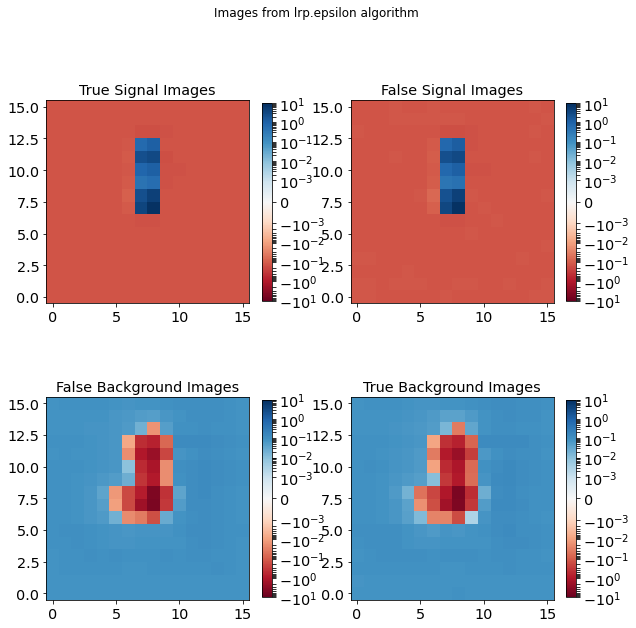

In [22]:
LRP_fct = 'lrp.epsilon'
Make_LRP_Images(model,
                X_lrp,
                Y_lrp,
                LRP_fct,
                confidence_cut)

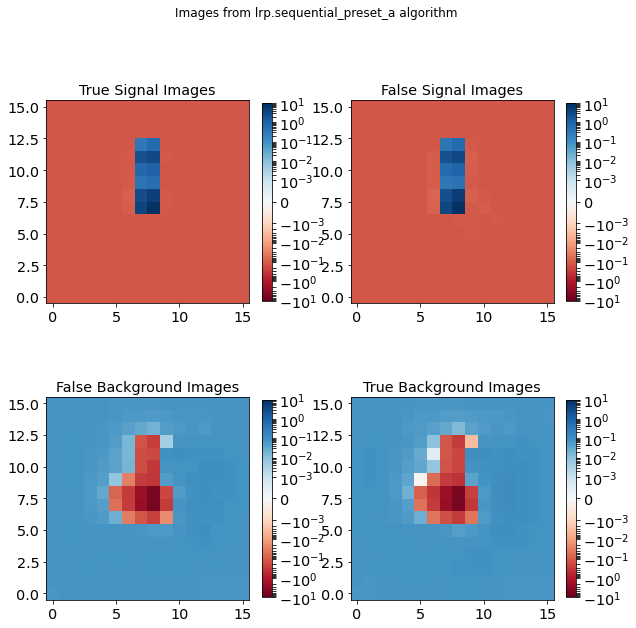

In [23]:
LRP_fct = 'lrp.sequential_preset_a'
Make_LRP_Images(model,
                X_lrp,
                Y_lrp,
                LRP_fct,
                confidence_cut)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


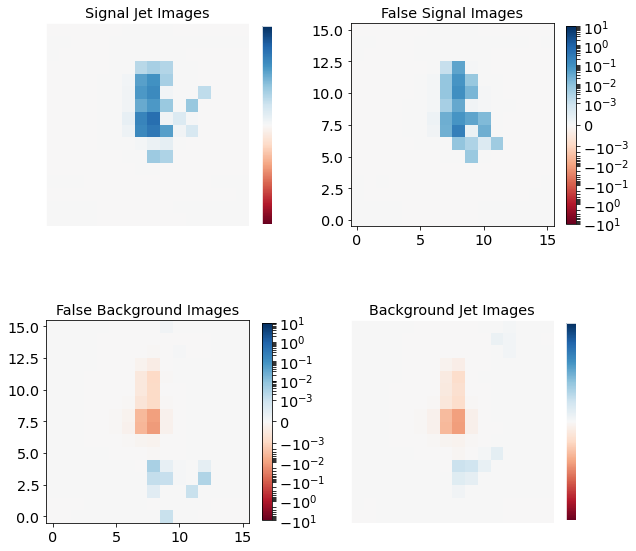

In [28]:
LRP_fct = 'lrp.sequential_preset_a'
Make_LRP_Images(model,
                X_lrp,
                Y_lrp,
                LRP_fct,
                confidence_cut,
                standardize=False)

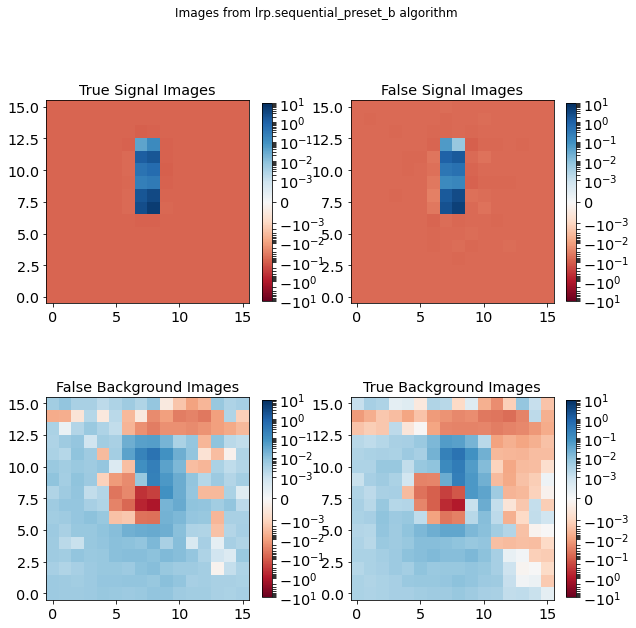

In [25]:
LRP_fct = 'lrp.sequential_preset_b'
Make_LRP_Images(model,
                X_lrp,
                Y_lrp,
                LRP_fct,
                confidence_cut)

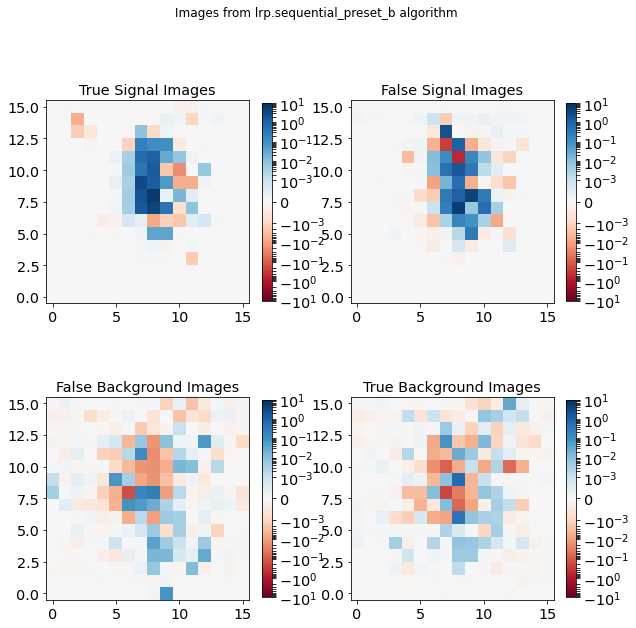

In [26]:
LRP_fct = 'lrp.sequential_preset_b'
Make_LRP_Images(model,
                X_lrp,
                Y_lrp,
                LRP_fct,
                confidence_cut,
                standardize=False)

# Model with Image + All Expert Variables

## Permutation Invariance

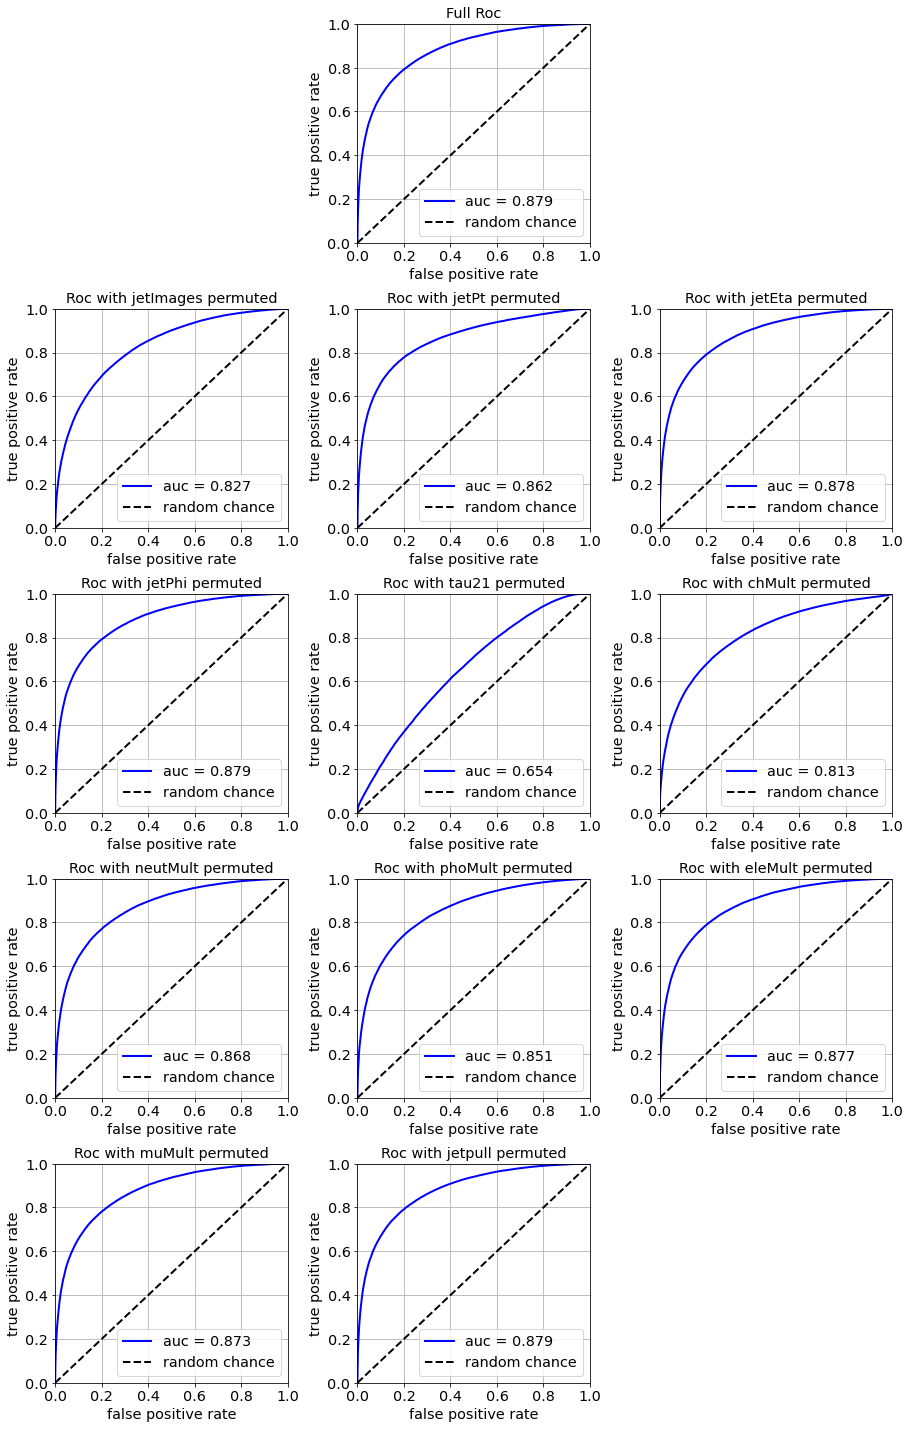

In [24]:
features = feat_all
label = ['labels']
X_test, Y_test = build_XY(features,label,data_test)

# Load Model
best_model = keras.models.load_model('model/CNN_all.h1')

# Build ROC curve for Unpermuted data, permutation of feature 0 and 1
fig = plt.figure(figsize=(15, 25))
fig_grid = plt.GridSpec(5, 3, wspace=0.3, hspace=0.3)
sub_p = [1 for j in range(len(features))]
for j in range(-1,len(features)):
    
    # Save Data in new list
    sub = [np.copy(ele) for ele in X_test]
    
    # permute feature j (j==-1 means leave unpermuted)
    if j > -1:
        np.random.shuffle(sub[j])
        
    # predict with new data
    predict = best_model.predict(sub)
    
    # Build ROC curve
    fpr, tpr, thresholds = roc_curve(Y_test[0][:,1], predict[:,1])
    roc_auc = auc(fpr, tpr)
    if j == -1:
        sub_p[j]=fig.add_subplot(fig_grid[0,1])
    else:
        row = int((j/3+1))
        col = (j%3)
        sub_p[j] = fig.add_subplot(fig_grid[row,col])
    sub_p[j].plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
    sub_p[j].plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
    sub_p[j].set_xlim([0, 1.0])
    sub_p[j].set_ylim([0, 1.0])
    sub_p[j].grid()
    sub_p[j].set_xlabel('false positive rate')
    sub_p[j].set_ylabel('true positive rate')
    if j == -1:
        sub_p[j].set_title('Full Roc')
    else:
        sub_p[j].set_title('Roc with ' + features[j] + ' permuted')
    sub_p[j].legend(loc="lower right")
    plt.savefig('plots/ROC_all.png')

## LRP new

In [60]:
features = feat_all
label = ['labels']
X_test, Y_test = build_XY(features,label,data_test)

# Load Model
full_model = keras.models.load_model('model/CNN_all.h4')

# Reshape Data, for easier application of LRP algorithm
X_lrp = [ [ X_test[i][j] for i in range(len(features)) ] for j in range(n_test) ]
for i in range(n_test):
    X_lrp[i][0] = X_lrp[i][0].reshape(1,grid,grid,1)

In [65]:
# Get LRP score
LRP_full = Get_LRP_Score(X_lrp, full_model, "lrp.epsilon")
LRP_sum = np.array([[np.sum(feature) for feature in ele] for ele in LRP_full])

# Get Full prediction for Confusion matrix split
pred_full = np.array([full_model.predict(X_lrp[i]) for i in range(n_test)])

### Histogram of LRP scores for features

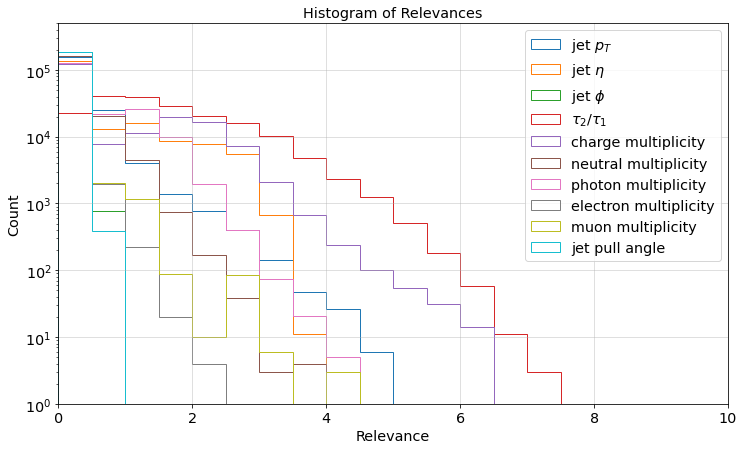

In [66]:
plt.figure(figsize=(12,7))
for i in range(1, len(LRP_sum[0])):
    plt.hist(np.abs(np.array(LRP_sum)[:,i]),
             bins = 20,
             range = [0,10],
             label = feature_names[i-1],
             histtype = 'step',
             log = True);
plt.legend()
plt.xlabel('Relevance')
plt.ylim(1,500000)
plt.xlim(0,10)
plt.grid(alpha=0.5)
plt.ylabel('Count')
plt.title('Histogram of Relevances')
plt.savefig('plots/LRP_histogram.png')

### Relevance profiles small

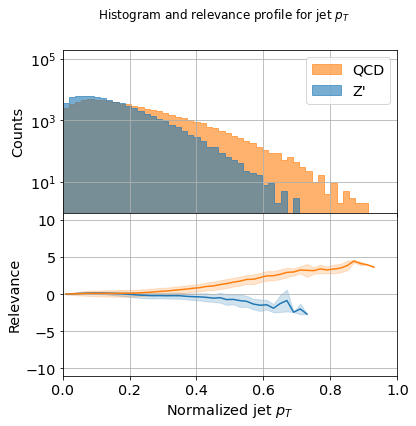

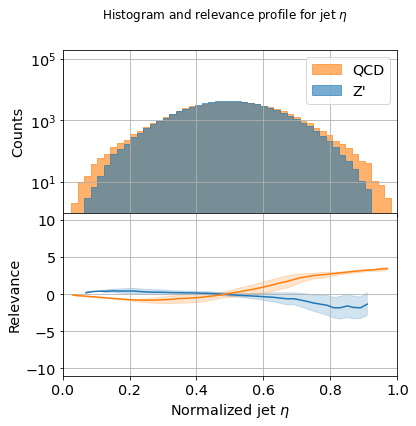

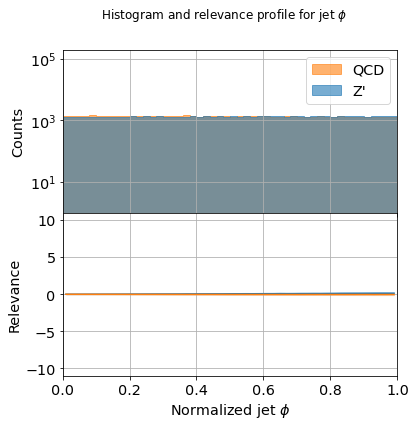

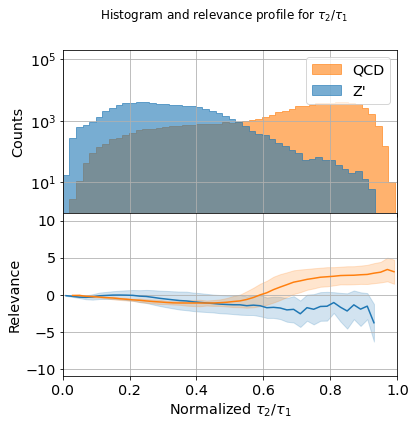

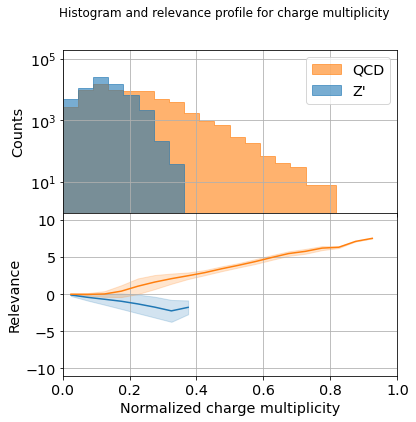

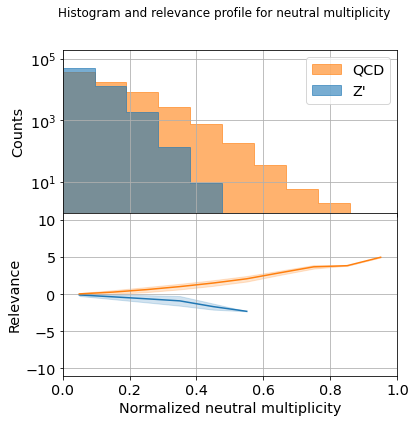

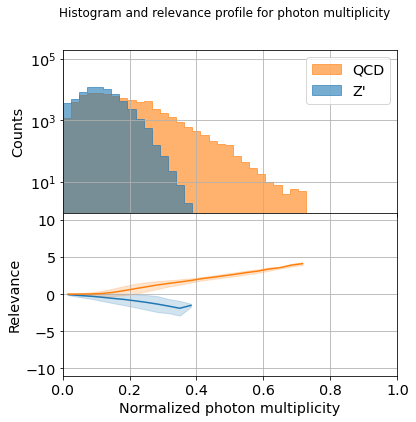

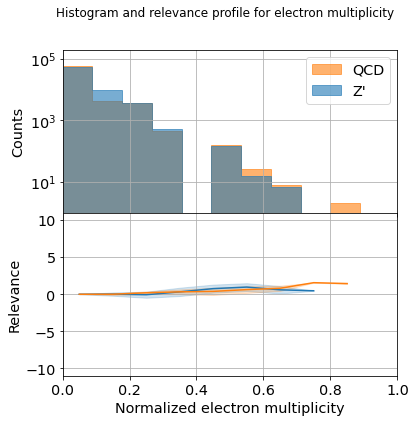

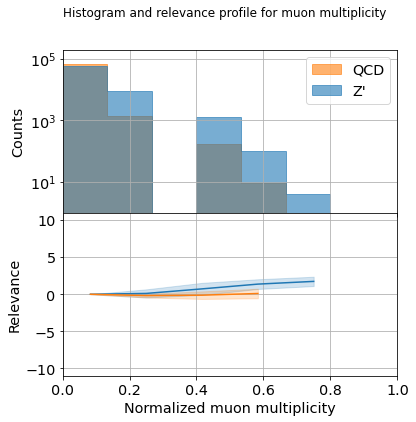

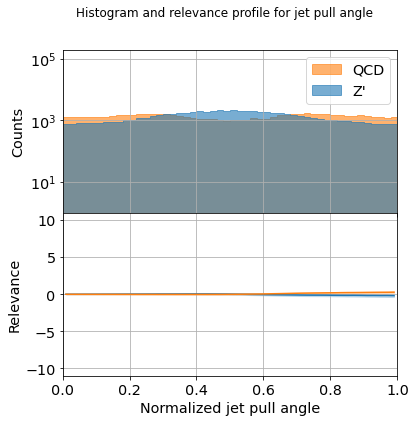

In [73]:
confidence_cut = 0.7
mybin = [50,50,50,50,20,10,30,10,6,50]
for feat in features[1:]:
    Draw_Profile_small(X_test,
                 Y_test,
                 pred_full,
                 LRP_sum,
                 confidence_cut,
                 feat,
                 mybin)

### Relevance profiles large 

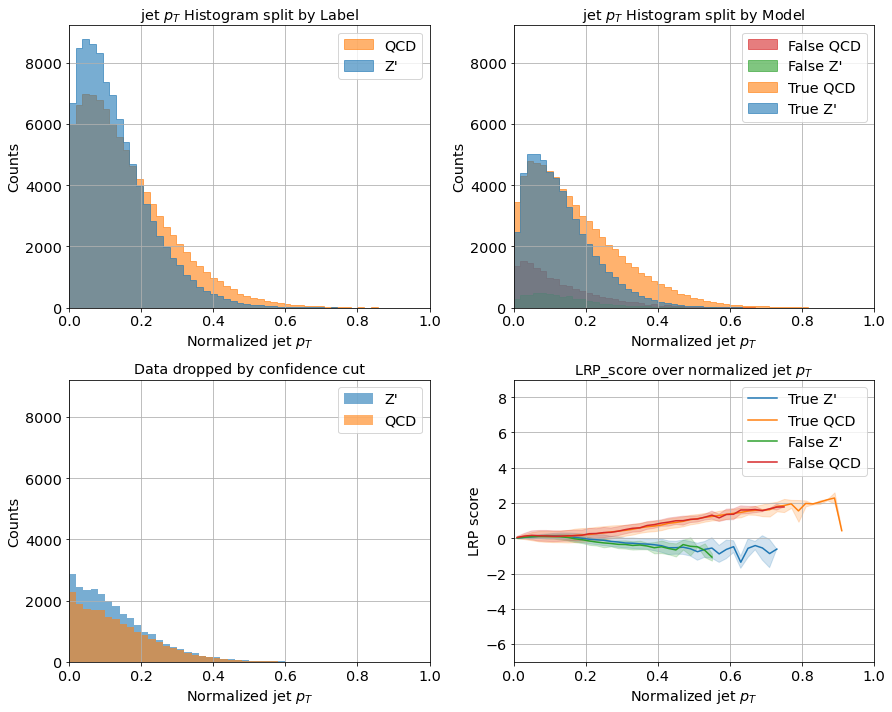

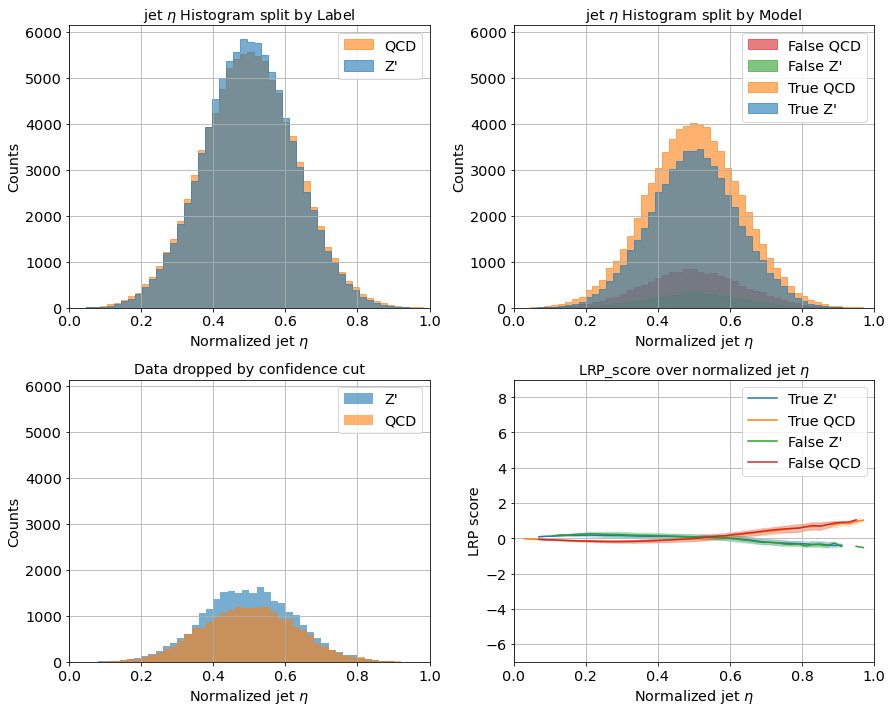

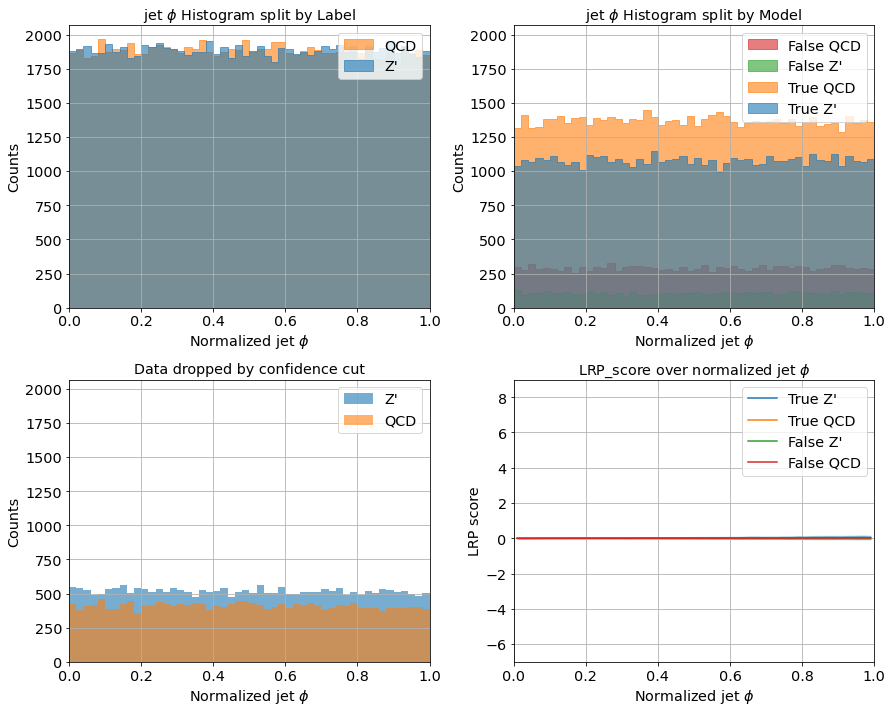

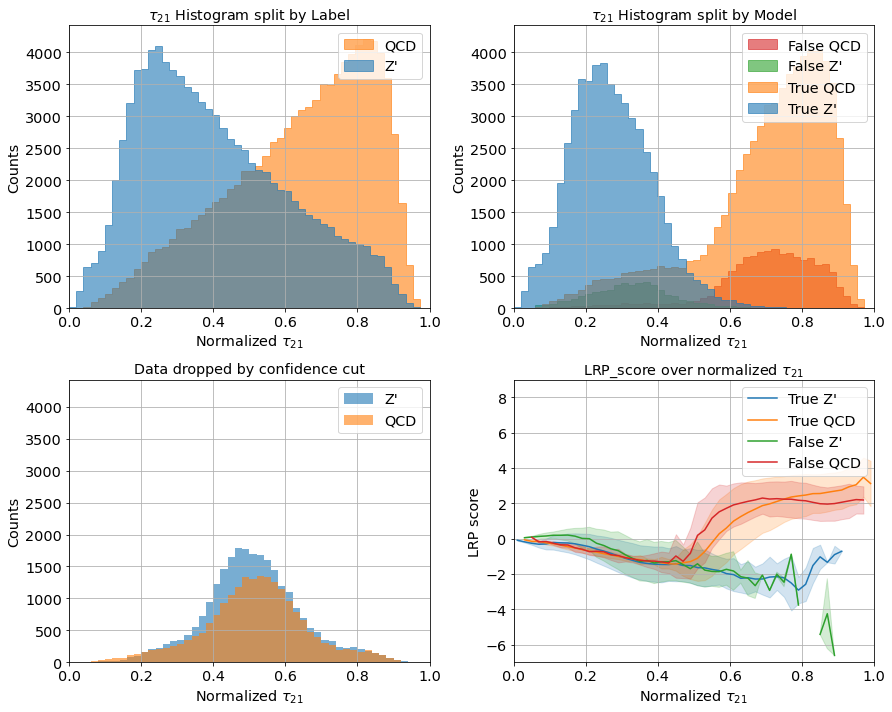

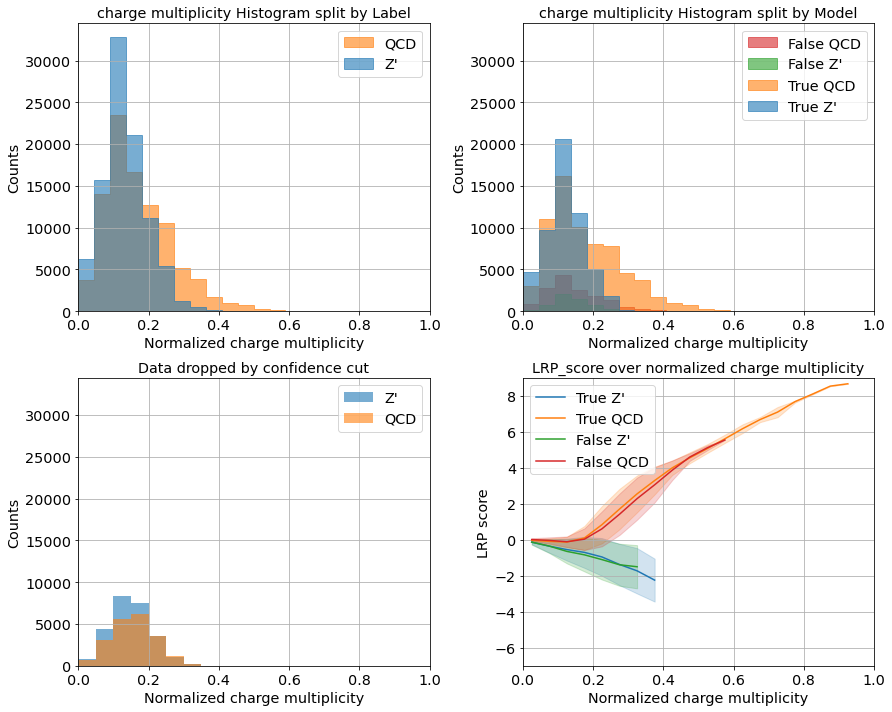

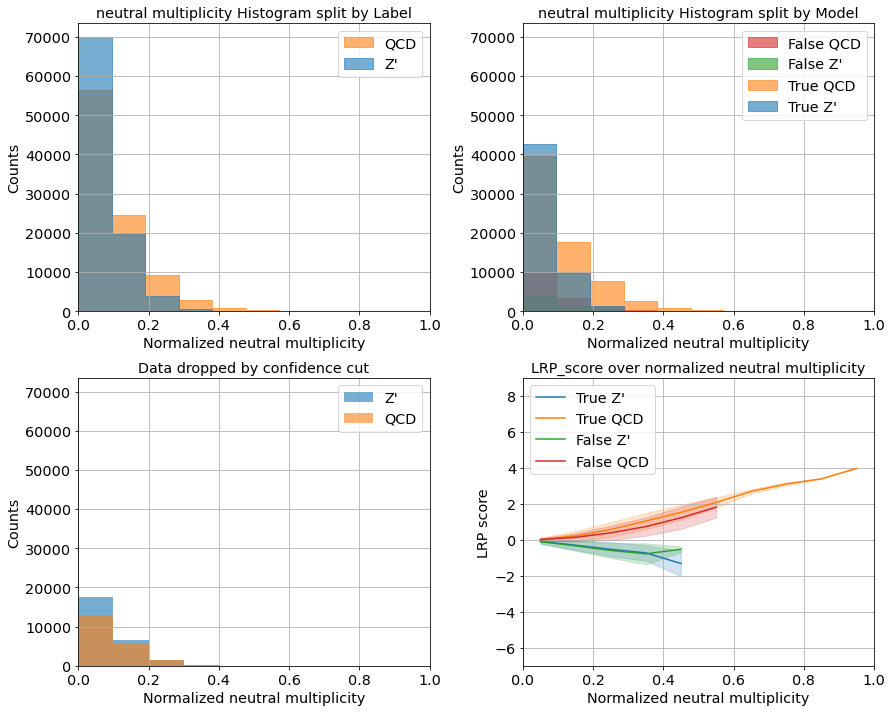

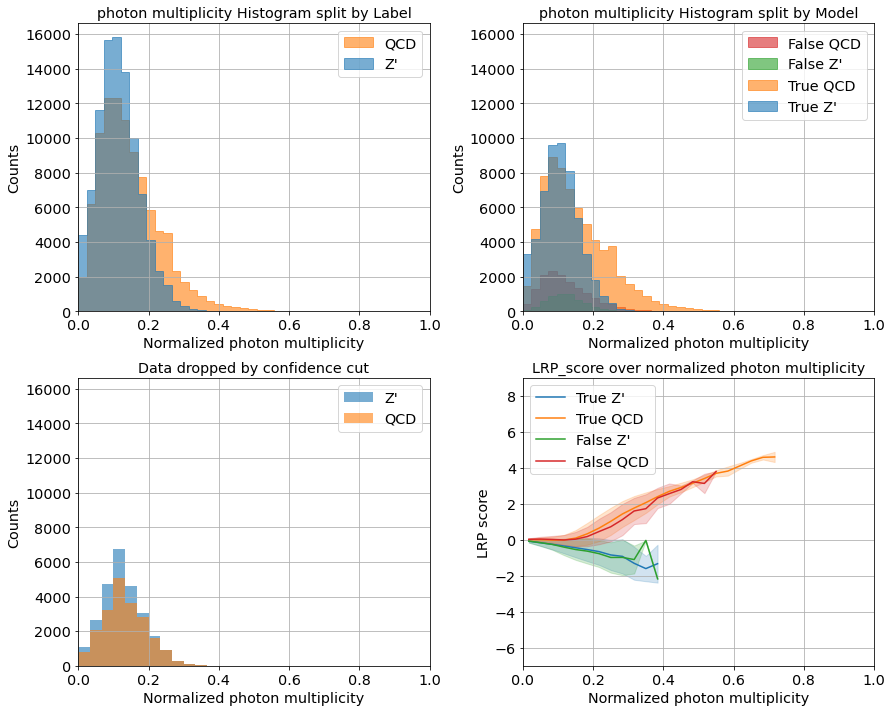

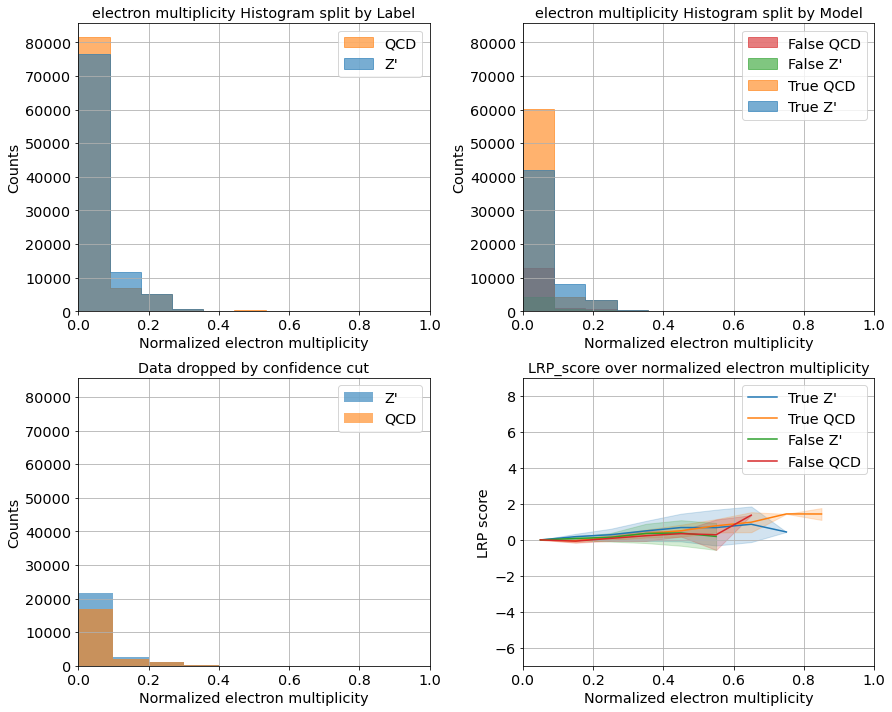

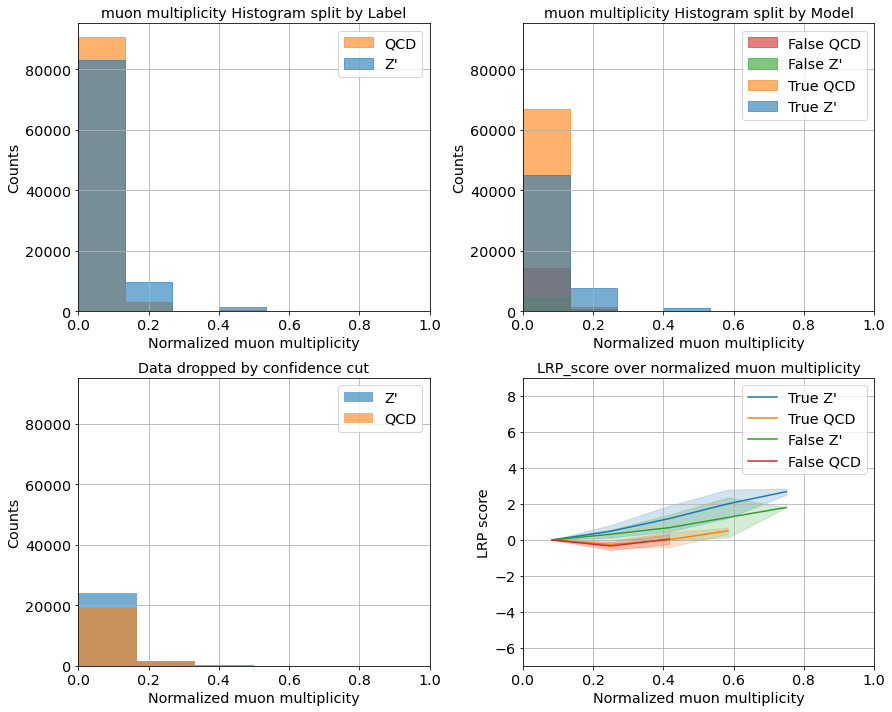

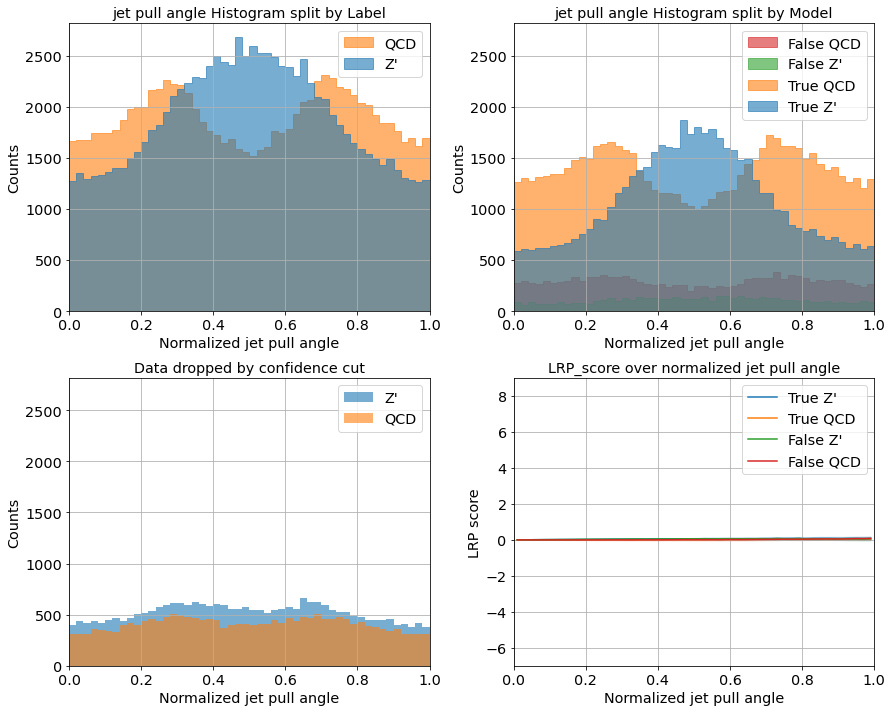

In [55]:
confidence_cut = 0.7
mybin = [50,50,50,50,20,10,30,10,6,50]
for feat in features[1:]:
    Draw_Profile(X_test,
                 Y_test,
                 pred_full,
                 LRP_sum,
                 confidence_cut,
                 feat,
                 mybin)

# Models with Image + 1 Expert Variable

## Permutation Invariance

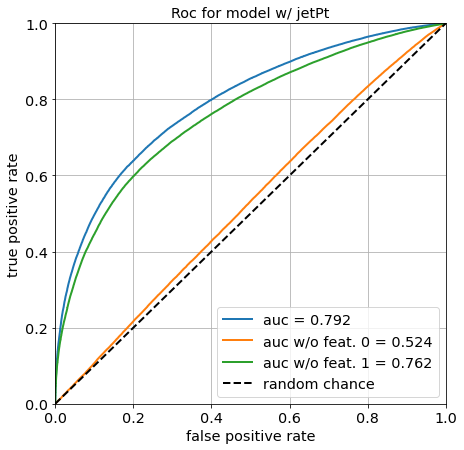

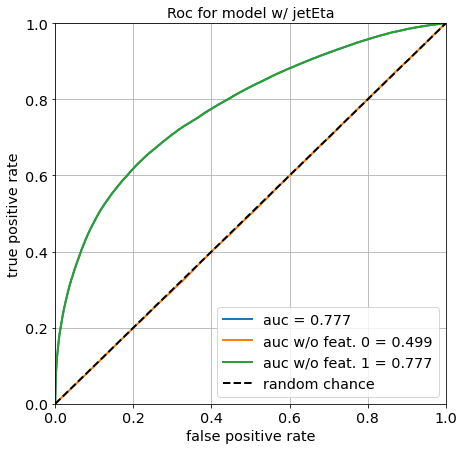

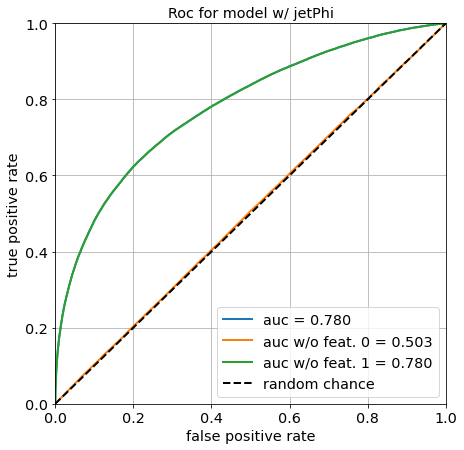

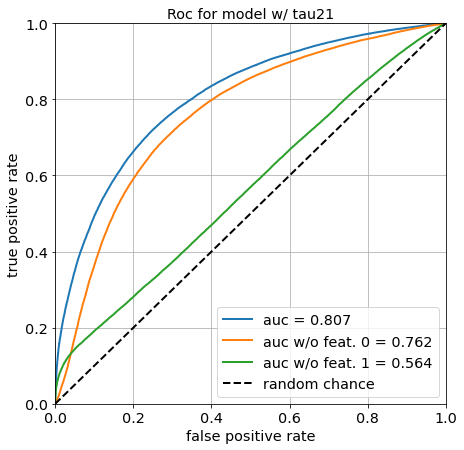

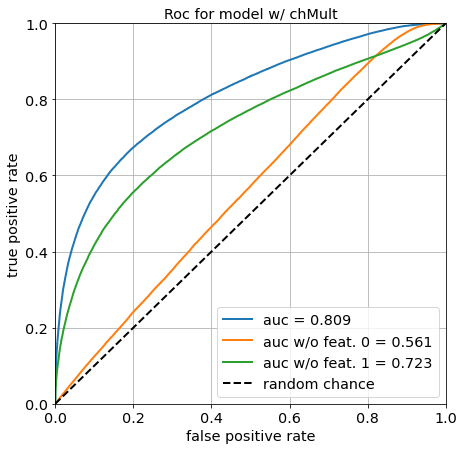

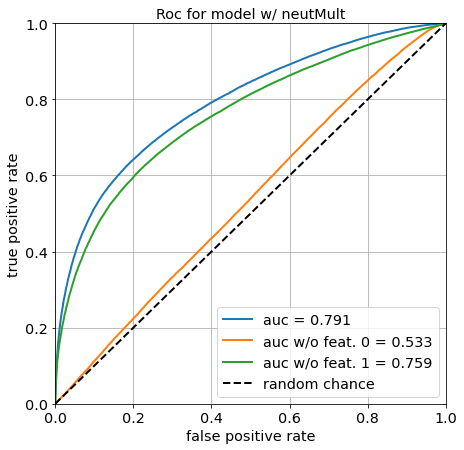

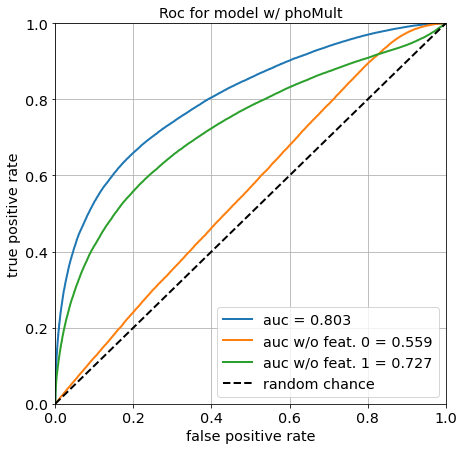

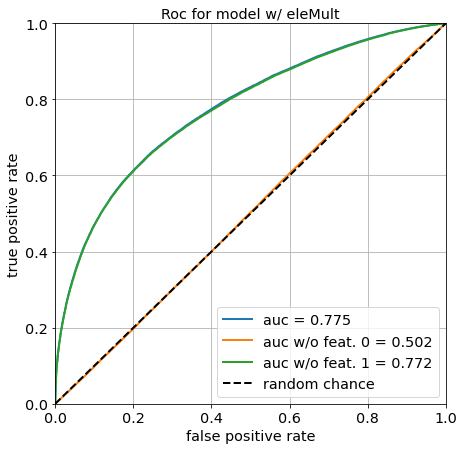

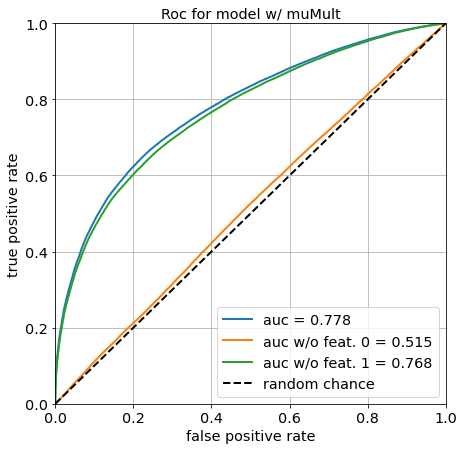

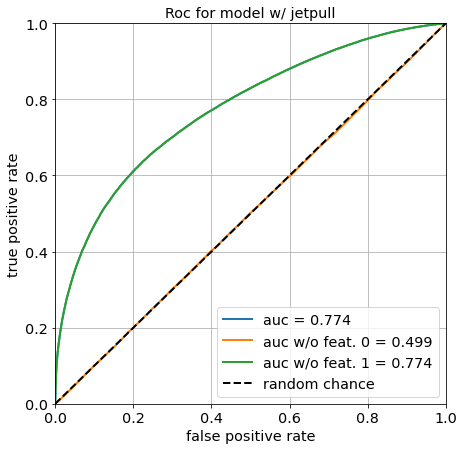

In [21]:
colors = ['C0', 'C1', 'C2']
for ii in range(1,len(feat_all)):
    
    # Select features and build X_test and Y_test
    features = ['jetImages']+[feat_all[ii]]
    label = ['labels']
    X_test, Y_test = build_XY(features, label, data_test)
    
    # Load Model
    best_model = keras.models.load_model('model/CNN_sub_' + str(ii) + '.h1')
    
    # Build ROC curve for Unpermuted data, permutation of feature 0 and 1
    fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize = (7,7))
    for j in range(-1,len(features)):
        
        # Save Data in new list
        sub = [np.copy(ele) for ele in X_test]
        
        # permute feature j (j==-1 means leave unpermuted)
        if j > -1:
            np.random.shuffle(sub[j])
            
        # predict with new data
        predict = best_model.predict(sub)
        
        # Build ROC curve
        fpr, tpr, thresholds = roc_curve(Y_test[0][:,1], predict[:,1])
        roc_auc = auc(fpr, tpr)
        if j == -1:
            ax.plot(fpr, tpr, lw = 2, color = colors[j+1], label = 'auc = %.3f' % (roc_auc))
        else:
            ax.plot(fpr, tpr, lw = 2, color = colors[j+1], label = 'auc w/o feat. ' + str(j) + ' = %.3f' % (roc_auc))
    
    ax.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'k', label = 'random chance')
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.grid()
    ax.set_xlabel('false positive rate')
    ax.set_ylabel('true positive rate')
    ax.set_title('Roc for model w/ ' + features[1] )
    ax.legend(loc="lower right")
    plt.savefig('plots/ROC2_'+features[1]+'.png')

# Analyze DNN

## Model with only Expert Variables

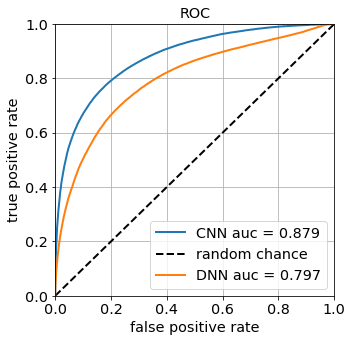

In [23]:
# build data for CNN
features = feat_all
label = ['labels']
X_test,Y_test = build_XY(features,label,data_test)

# Load Model
best_model = keras.models.load_model('model/CNN_all.h1')
predict = best_model.predict(X_test)

# Build ROC curve for CNN
fpr, tpr, thresholds = roc_curve(Y_test[0][:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5))
ax.plot(fpr,
           tpr,
           lw = 2,
           color = 'C0',
           label = 'CNN auc = %.3f' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'k', label = 'random chance')


# data for DNN
features = feat_all[1:]
label = ['labels']
X_test, Y_test = build_XY(features,label,data_test)

# Load Model
best_model = keras.models.load_model('model/DNN_all.h1')
predict = best_model.predict(X_test)

# Build ROC curve for DNN
fpr, tpr, thresholds = roc_curve(Y_test[0][:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
ax.plot(fpr,
        tpr,
        lw = 2,
        color = 'C1',
        label = 'DNN auc = %.3f' % (roc_auc))
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.grid()
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_title('ROC')
ax.legend(loc = "lower right")

plt.savefig('plots/CNN_DNN_full.png')